In [1]:
import numpy as np
from dobbel import dobbellogger
from help_functies import *
from calibrator4 import *
from matrix_helper import *
import matplotlib.pyplot as plt
import pandas as pd
dob = dobbellogger()

In [2]:
cali = calibrate(dob, 2, 1, 100, 2, 125)
acc_std = cali['acc std']
gyro_std = cali['gyro std']
print(cali)

Leg de dobbelsteen met nummer  1  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  2  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  3  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  4  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  5  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  6  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
{'gyro bias': array([-0.14750725,  0.48880137,  0.04937339]), 'gyro std': array([0.00522173, 0.01541666, 0.00570179]), 'acc bias': array([ 0.00213097, -0.00415587,  0.01011201]), 'acc std': array([0.00113517, 0.00059189, 0.00113338])}


In [3]:
q_rot = rotate_cali(dob, cali, 2, 1, 100, 2, 125)

Leg de dobbelsteen met de 1 naarboven
Wacht 1 seconden
Loggen voor 2 seconden
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met de 2 naarboven
Wacht 1 seconden
Loggen voor 2 seconden
Logging data for 2s
Done! The data is located in self.datadf


In [27]:
dob.connect()
dob.log(5, 100, 2, 125)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [28]:
data = remove_nan(data)

data['x_acc'] = data['x_acc'] - cali['acc bias'][0]
data['y_acc'] = data['y_acc'] - cali['acc bias'][1]
data['z_acc'] = data['z_acc'] - cali['acc bias'][2]
data['x_gyro'] = data['x_gyro'] - cali['gyro bias'][0]
data['y_gyro'] = data['y_gyro'] - cali['gyro bias'][1]
data['z_gyro'] = data['z_gyro'] - cali['gyro bias'][2]
data = rotate_data(data, q_rot)

for column in data.columns:
    print(column, np.mean(data[column]))

timestamp 2462.3468992248063
x_acc 0.0019382795415093105
y_acc 1.0016600458823306
z_acc 0.032260482950040366
x_gyro 0.009267857342718653
y_gyro 0.029112465327105486
z_gyro -0.003872213389719304


In [29]:
data.head()

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,0.002618,1.004762,0.035147,0.083394,-0.073594,-0.333885
1,21.0,0.000429,0.999543,0.031042,0.368892,0.059707,0.459222
2,31.0,0.001000,1.004578,0.032429,0.023008,0.018034,-0.076543
3,41.0,0.000131,1.003318,0.033634,0.024021,0.021907,-0.046079
4,50.0,-0.001127,1.001502,0.032288,0.026946,-0.035556,0.031498


In [30]:
y11 = np.array([np.mean(data['x_acc'][0:10]), np.mean(data['y_acc'][0:10]), np.mean(data['z_acc'][0:10])])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
ymb= np.array([1, 2, 3])
mb = np.array([1, 0, 0]) #np.cross(gb, np.cross(ymb / np.linalg.norm(ymb), gb))

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
q11 = max_eigenvector

In [31]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11_rot = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))
v11 = np.array([0,0,0])
p11 = np.array([0,0,0])

In [32]:
Q_gyro = np.array([
    [gyro_std[0] ** 2, 0, 0],
    [0, gyro_std[1] ** 2, 0],
    [0, 0, gyro_std[2] ** 2]
])
Q_pv_std = 0.0001
Q_pv = Q_pv_std * np.eye(6)
Q = np.vstack([np.hstack([Q_pv, np.zeros((6, 3))]), np.hstack([np.zeros((3, 6)), Q_gyro])])

small_R = 10 * np.array([
    [acc_std[0] ** 2, 0, 0],
    [0, acc_std[1] ** 2, 0],
    [0, 0, acc_std[2] ** 2],
])

R_pzv_std = 0.0001
R_pzv = R_pzv_std * np.eye(4)
large_R = np.vstack([np.hstack([R_pzv, np.zeros((4, 3))]), np.hstack([np.zeros((3, 4)), small_R])])

Ppvstd = 0
P11 = np.vstack([np.hstack([Ppvstd * np.eye(6), np.zeros((6, 4))]), np.hstack([np.zeros((4, 6)), P11_rot])])

#P11 = np.vstack([np.zeros((6,10)), np.hstack([np.zeros((4, 6)), P11_rot])])

In [33]:
print(P11)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00

In [34]:
zv_data = zv_checker(data, 5, 0.05)
print(len(zv_data))
count = 0
for bool in zv_data['zero velocity']:
    if bool:
        count += 1
print(count)
print(list(zv_data['zero velocity']))

516
505
[False, False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, T

In [150]:
xtmin1tmin1 = np.concatenate([p11, v11, q11])
Ptmin1tmin1 = P11

x_list = [xtmin1tmin1]
epsilon_list = []
ygnrot_list = []
yab_list = []

K_list = []
P_list = []

an_list = []

for i in range(1, len(zv_data['timestamp'])):
    dt = (zv_data['timestamp'][i] - zv_data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([zv_data['x_gyro'][i], zv_data['y_gyro'][i], zv_data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    ptmin1tmin1 = xtmin1tmin1[:3]
    vtmin1tmin1 = xtmin1tmin1[3:6]
    qtmin1tmin1 = xtmin1tmin1[6:]

    yat_b = np.array([zv_data['x_acc'][i], zv_data['y_acc'][i], zv_data['z_acc'][i]])
    yat_n = rotate_vector(gn, quaternion_conjugate(np.reshape(qtmin1tmin1, 4)))
    ygnrot_list.append(yat_n)
    yab_list.append(yat_b)
    
    an_list.append(rotate_vector(yat_b, np.reshape(qtmin1tmin1, 4)) - gn)
    
    pttmin1 = ptmin1tmin1 + dt * vtmin1tmin1 + 0.5 * (rotate_vector(yat_b, np.reshape(qtmin1tmin1, 4)) - gn) * 9.81 * dt ** 2
    vttmin1 = vtmin1tmin1 + dt * (rotate_vector(yat_b, np.reshape(qtmin1tmin1, 4)) - gn) * 9.81
    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)
    xttmin1 = np.concatenate([pttmin1, vttmin1, qttmin1])

    Ftmin1 = calculate_F(xttmin1, omega, yat_b * 9.81, dt)
    Gtmin1 = calculate_G(xttmin1, dt)
    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)
    P_list.append(Ptmin1tmin1)
    if False: #zv_data['zero velocity'][i]:
        H = calculate_large_H(xttmin1)
        S = np.matmul(np.matmul(H, Pttmin1), H.T) + large_R
        K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))
        yateps_rot = yat_b #/ np.linalg.norm(yat_b)
        yattmin1_rot = rotate_vector(gn, quaternion_conjugate(np.reshape(qttmin1, 4)))
        epsilon_rot = yateps_rot - yattmin1_rot
        ypzv_est = np.array([pttmin1[2], *vttmin1])
        ypzv_mea = np.zeros(4)
        epsilon_pos = np.reshape(ypzv_mea - ypzv_est, (4, 1))
        epsilon = np.vstack([epsilon_pos, np.reshape(epsilon_rot, (3, 1))])
        x_tt_measure = np.reshape(xttmin1, (10, 1)) + np.matmul(K, epsilon)
    else:
        H = calculate_small_H(xttmin1)
        S = np.matmul(np.matmul(H, Pttmin1), H.T) + small_R
        K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))
        
        K_list.append(K)
        
        yateps = yat_b #/ np.linalg.norm(yat_b)
        yattmin1 = rotate_vector(gn, quaternion_conjugate(np.reshape(qttmin1, 4)))
        epsilon = np.reshape(yateps - yattmin1, (3, 1))
        x_tt_measure = np.reshape(xttmin1, (10, 1)) + np.matmul(K, epsilon)

    epsilon_list.append(epsilon)

    Ptt = Pttmin1 - np.matmul(np.matmul(K, H), Pttmin1)
    x_tt_measure = np.reshape(x_tt_measure, 10)
    x_tt = np.concatenate([x_tt_measure[:6], x_tt_measure[6:] / np.linalg.norm(x_tt_measure[6:])])
    
    Ptmin1tmin1 = Ptt
    xtmin1tmin1 = x_tt
    x_list.append(x_tt)

x_array = np.reshape(np.concatenate(x_list), (len(x_list), 10))
results = pd.DataFrame(x_array, columns=['px', 'py', 'pz', 'vx', 'vy', 'vz', 'q0', 'q1', 'q2', 'q3'])
results.head(1000)

,px,py,pz,vx,vy,vz,q0,q1,q2,q3
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.718391,-0.695640,0.000236,-0.000228
1,0.000743,0.005660,-0.000006,0.070770,0.539088,-0.000537,-0.720706,-0.692908,-0.019663,-0.008585
2,0.001145,0.008477,-0.000007,0.056832,0.413733,-0.000145,-0.720701,-0.692915,-0.019644,-0.008574
3,0.001719,0.012600,-0.000007,0.058373,0.413788,0.000221,-0.720699,-0.692917,-0.019646,-0.008573
4,0.002250,0.016327,-0.000004,0.059702,0.414437,0.000387,-0.720697,-0.692919,-0.019641,-0.008574
...,...,...,...,...,...,...,...,...,...,...
511,2.289955,2.788245,0.243254,0.871667,0.730589,0.095621,-0.720208,-0.693408,-0.019711,-0.009854
512,2.298684,2.795554,0.244212,0.874087,0.731179,0.095891,-0.720205,-0.693411,-0.019707,-0.009867
513,2.307436,2.802869,0.245172,0.876357,0.731699,0.096055,-0.720203,-0.693413,-0.019715,-0.009873
514,2.317090,2.810919,0.246230,0.878859,0.731983,0.096393,-0.720199,-0.693416,-0.019723,-0.009874


In [151]:
for k in K_list[:10]:
    print(k[4,:])

[ -943.05613203 -1891.546878    -275.27739436]
[ -4.51446231 -10.85791125  -1.85680413]
[-0.02184213 -0.0571986  -0.0104747 ]
[-9.88746118e-05 -2.47104244e-04 -3.77770800e-05]
[-4.97684859e-08 -1.16723166e-07 -1.25110947e-08]
[-1.93246252e-10 -7.27864862e-10  7.80146628e-10]
[-5.16602772e-09  1.88378696e-08  1.11002902e-07]
[-1.15834033e-08  2.04143586e-08  1.37124568e-07]
[-9.82995284e-09 -1.74658110e-08  1.03933978e-07]
[-5.77905071e-09 -3.66335977e-09  1.07942572e-07]


In [152]:
from IPython.display import display, Math, Latex
def array_to_latex(arr):
    latex_str = r'\begin{bmatrix}'
    for row in arr:
        row_str = ' & '.join(map(str, row))
        latex_str += row_str + r'\\'
    latex_str += r'\end{bmatrix}'
    return latex_str


In [153]:
gnrots = np.reshape(np.concatenate(ygnrot_list), (int(len(ygnrot_list)), 3))
for i in range(3):
    print(np.mean(ans[:,i]))

-0.015401973132097267
0.9991537820399271
0.03812559344873218


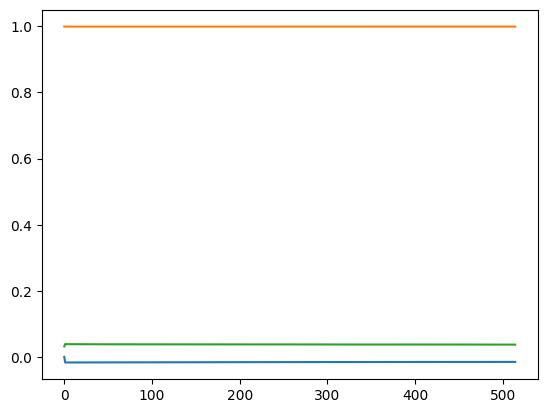

In [154]:
plt.plot(ans[:,0])
plt.plot(ans[:,1])
plt.plot(ans[:,2])
plt.show()

In [155]:
yabs = np.reshape(np.concatenate(yab_list), (int(len(yab_list)), 3))
for i in range(3):
    print(np.mean(yabs[:,i]))

0.0019369603799136055
1.0016540225760384
0.03225487832634242


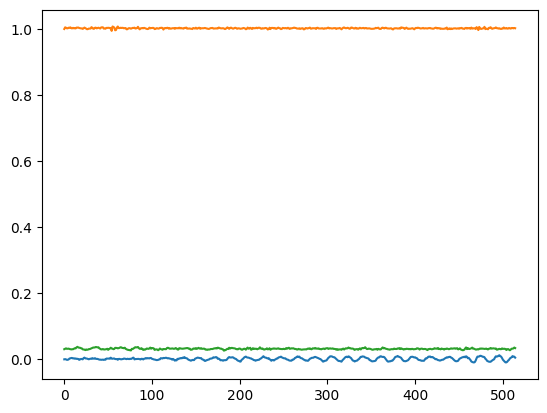

In [156]:
plt.plot(yabs[:,0])
plt.plot(yabs[:,1])
plt.plot(yabs[:,2])
plt.show()

In [157]:
print(np.linalg.norm(np.mean(yabs, axis=0)))

1.0021750894599801


In [158]:
plot_x = []
plot_y = []
plot_z = []

for x, timestamp in zip(x_list, data['timestamp']):
    euler = quaternion_to_euler(x[6:]) * 180 / np.pi
    plot_x.append(euler[0])
    plot_y.append(euler[1])
    plot_z.append(euler[2])

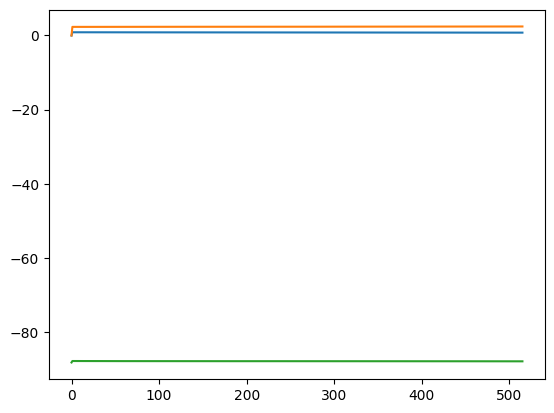

In [159]:
plt.plot(plot_x)
plt.plot(plot_y)
plt.plot(plot_z)

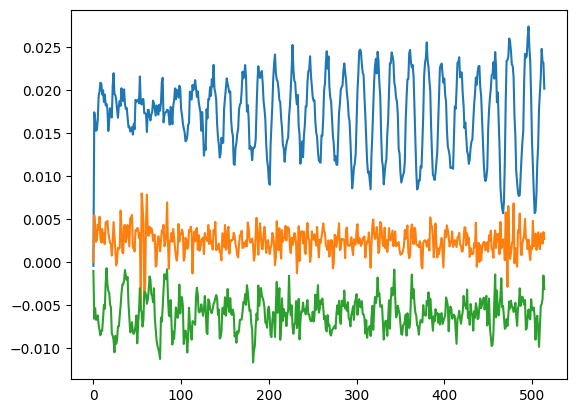

In [160]:
epsilon_rot = []
for e in epsilon_list:
    epsilon_rot.append(e[-3:, 0])
    
epsilons = np.concatenate(epsilon_rot)
epsilons = np.reshape(epsilons, (int(len(epsilons) / 3), 3))

plt.plot(epsilons[:, 0])
plt.plot(epsilons[:, 1])
plt.plot(epsilons[:, 2])

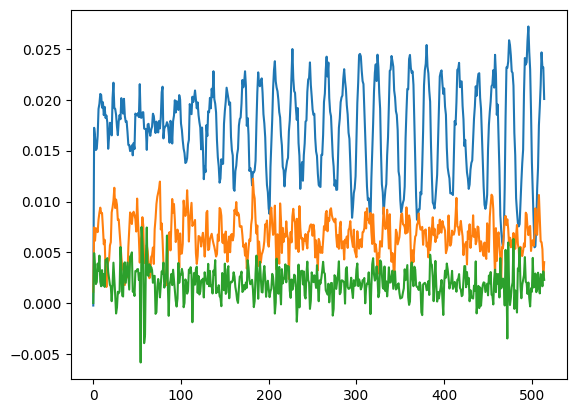

In [161]:
yans = np.reshape(np.concatenate(an_list), (len(an_list), 3))
plt.plot(yans[:,0])
plt.plot(yans[:,1])
plt.plot(yans[:,2])
plt.show()

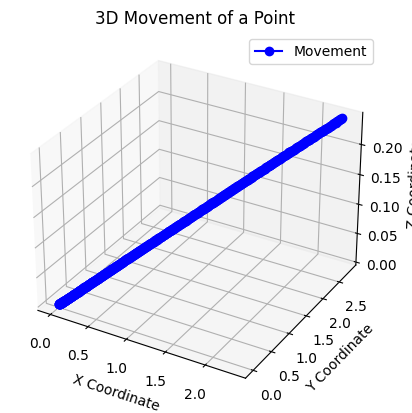

In [162]:
positions = x_array[:,:3]
# Create a new figure for the 3D plot
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the movement of the point
ax.plot(positions[:,0], positions[:,1], positions[:,2], marker='o', linestyle='-', color='b', label='Movement')

# Set labels for each axis
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set a title
ax.set_title('3D Movement of a Point')

# Add a legend
ax.legend()

# Show the plot
plt.show()

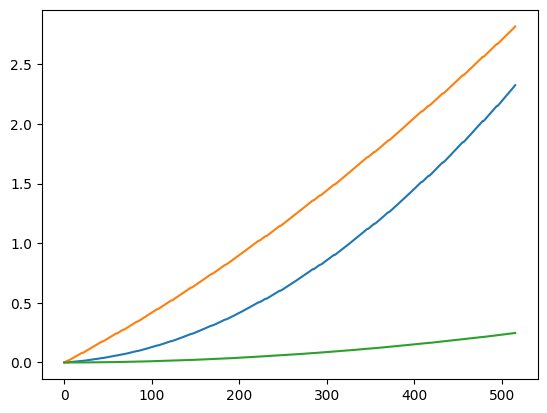

In [163]:
plt.plot(positions[:,0])
plt.plot(positions[:,1])
plt.plot(positions[:,2])
plt.show()

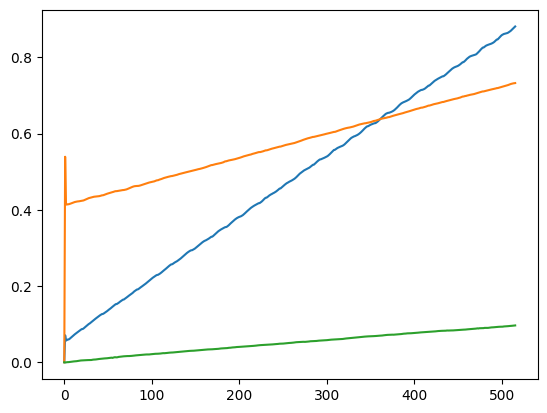

In [164]:
velocities = x_array[:,3:6]
plt.plot(velocities[:, 0])
plt.plot(velocities[:, 1])
plt.plot(velocities[:, 2])
plt.show()

In [165]:
dob.disconnect()

we are disconnected!
